# Jet pt and mass "inverting" regression with omnifold

In [1]:
import numpy as np
import uproot
import aiohttp
from matplotlib import pyplot as plt
import awkward as ak
from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

#####
#Delta R matched

2024-06-24 15:09:23.330409: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
coffea.__version__

'2024.5.0'

### Check to see if a GPU is present for acceleration

In [3]:
####
# Not necessary, just a device check. Remove if desired
###
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
print(tf.config.list_physical_devices('GPU'))

['/device:CPU:0']
[]


In [4]:
####
# Not necessary, just a device check. Remove if desired
###
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[]


### Get leading generator-level ("truth" or "gen") jet and match to the nearest reconstructed-level ("reco") jet

In [5]:
#coffea init
cofevents = NanoEventsFactory.from_root( {'QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8_NANOAODSIM_7F142AC6-39F2-2F4F-9F97-C425A1C99A35.root':'Events'}, schemaclass=NanoAODSchema).events()
####

# Filter 0s 
cevents = cofevents[ak.num(cofevents.FatJet)>0]
cevents = cevents[ak.num(cevents.GenJetAK8)>0]
fj = cevents.FatJet
gj = cevents.GenJetAK8


#this should give fatjets closest to genjets, and since genjets are already stripped of zeroes, this should just line up (pfft just kidding)
nearest_fj = gj.nearest(fj)

gj0 = gj[:,0]          # Leading generator-level (gen) jet
fj0 = nearest_fj[:,0]  # Reco jet that matches leading gen jet

/usr/local/lib/python3.11/dist-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


### Compute $\Delta R$ between leading gen jet and matched reco jet. Require to be $< 0.2$

In [6]:
# Calculate delta r
gj_deltar_fj = gj0.delta_r(fj0)
# Find events where the delta r is < 0.2
pass_dr = gj_deltar_fj < 0.2
gj0 = gj0[pass_dr]
fj0 = fj0[pass_dr]

### Divide into even and odd events to test and train the neural network

In [7]:
#pick lowest size
size_odd = len(gj0.pt[1::2])
size_even = len(gj0.pt[0::2])
size_all = size_even if size_odd > size_even else size_odd

In [8]:
even_gj0 = gj0[0::2][0:size_all]
odd_gj0 = gj0[1::2][0:size_all]
even_fj0 = fj0[0::2][0:size_all]
odd_fj0 = fj0[1::2][0:size_all]

### Arrange the jet pt and mass into the format omnifold expects

General plan is to add jet composition variables to this array and see if the resolution of the regression improves

In [9]:

odd_gen = np.column_stack((
    ak.to_numpy( odd_gj0.mass.compute() ),
    ak.to_numpy( odd_gj0.pt.compute() )
))

odd_reco = np.column_stack((
    ak.to_numpy( odd_fj0.mass.compute() ),
    ak.to_numpy( odd_fj0.pt.compute() )
))

even_gen = np.column_stack([
    ak.to_numpy(even_gj0.mass.compute() ),
    ak.to_numpy(even_gj0.pt.compute() )
])

even_reco = np.column_stack([
    ak.to_numpy(even_fj0.mass.compute() ) ,
    ak.to_numpy(even_fj0.pt.compute() )
])

theta0 = np.stack((odd_gen, odd_reco), axis=1)

print("CLEAR")

CLEAR


In [10]:
odd_gen.shape

(149480, 2)

In [11]:
print(odd_gen)
print(even_gen)
print(theta0)

[[  46.5     1373.5568 ]
 [ 139.375    920.85974]
 [  96.0625  1510.5403 ]
 ...
 [ 218.625   4182.6987 ]
 [  52.25     661.56055]
 [ 397.5     5961.3716 ]]
[[  61.21875   378.66748 ]
 [  61.6875    717.35364 ]
 [ 140.625     345.20975 ]
 ...
 [  22.046875  412.8385  ]
 [ 118.3125   4407.2573  ]
 [ 148.625    2303.6921  ]]
[[[  46.5     1373.5568 ]
  [  70.75    1454.     ]]

 [[ 139.375    920.85974]
  [ 132.25     885.5    ]]

 [[  96.0625  1510.5403 ]
  [  85.375   1517.     ]]

 ...

 [[ 218.625   4182.6987 ]
  [ 263.25    4220.     ]]

 [[  52.25     661.56055]
  [  65.75     668.5    ]]

 [[ 397.5     5961.3716 ]
  [ 488.75    6184.     ]]]


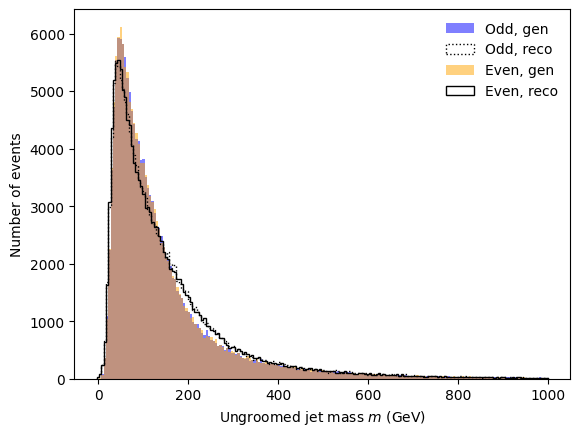

In [12]:
_,_,_=plt.hist(odd_gen[:,0],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="Odd, gen")
_,_,_=plt.hist(odd_reco[:,0],bins=np.linspace(-3,1000,200),histtype="step",color='black',ls=':',label="Odd, reco")
_,_,_=plt.hist(even_gen[:,0],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="Even, gen")
_,_,_=plt.hist(even_reco[:,0],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="Even, reco")
plt.xlabel("Ungroomed jet mass $m$ (GeV)")
plt.ylabel("Number of events")
plt.legend(frameon=False)



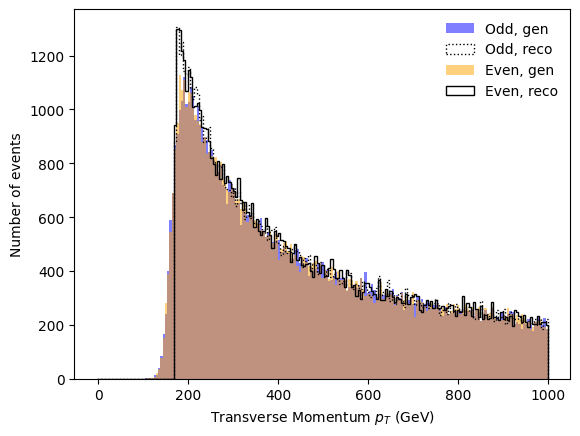

In [13]:
_,_,_=plt.hist(odd_gen[:,1],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="Odd, gen")
_,_,_=plt.hist(odd_reco[:,1],bins=np.linspace(-3,1000,200),histtype="step",color='black',ls=':',label="Odd, reco")
_,_,_=plt.hist(even_gen[:, 1],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="Even, gen")
_,_,_=plt.hist(even_reco[:, 1],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="Even, reco")
plt.xlabel("Transverse Momentum $p_{T}$ (GeV)")
plt.ylabel("Number of events")
plt.legend(frameon=False)


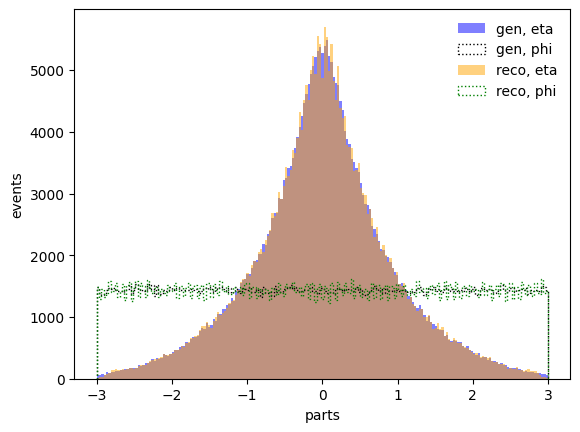

In [14]:
_,_,_=plt.hist(gj0.eta.compute(),bins=np.linspace(-3,3,200),color='blue',alpha=0.5,label="gen, eta")
_,_,_=plt.hist(gj0.phi.compute(),bins=np.linspace(-3,3,200),histtype="step",color='black',ls=':',label="gen, phi")
_,_,_=plt.hist(fj0.eta.compute(),bins=np.linspace(-3,3,200),color='orange',alpha=0.5,label="reco, eta")
_,_,_=plt.hist(fj0.phi.compute(),bins=np.linspace(-3,3,200),histtype="step",color='green',ls=':',label="reco, phi")
#_,_,_=plt.hist(jet_genmass[:],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="Data, true")
#_,_,_=plt.hist(jet_genpt[:],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="Data, reco")
plt.xlabel("parts")
plt.ylabel("events")
plt.legend(frameon=False)

In [51]:
import matplotlib as mpl

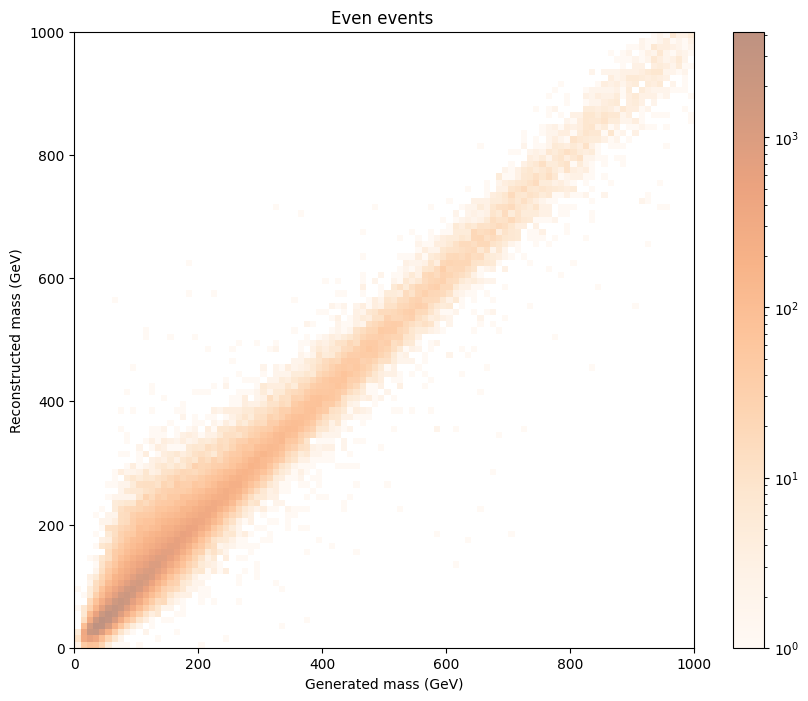

In [60]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(even_gen[:, 0], even_reco[:, 0], 
           bins=(np.linspace(0,1000,101), np.linspace(0,1000,101)), 
           cmap='Oranges', alpha=0.5, label="Data, true",
           norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel("Generated mass (GeV)")
plt.ylabel("Reconstructed mass (GeV)")
plt.title("Even events ")
plt.show()

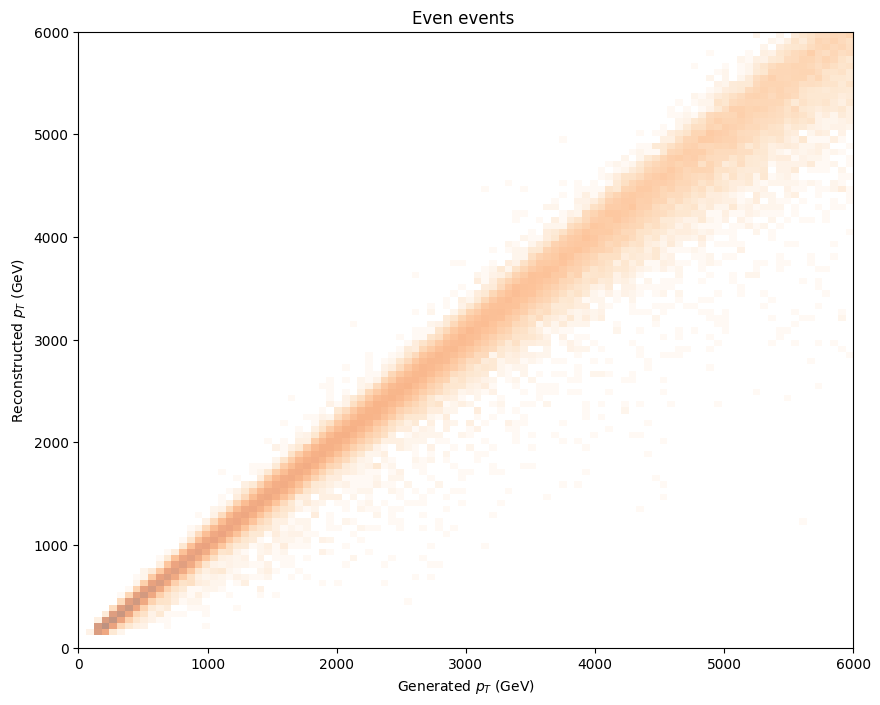

In [62]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(even_gen[:, 1], even_reco[:, 1], 
           bins=(np.linspace(0,6000,101), np.linspace(0,6000,101)), 
           cmap='Oranges', alpha=0.5, label="Data, true",
           norm=mpl.colors.LogNorm())
#plt.colorbar()
plt.xlabel("Generated $p_T$ (GeV)")
plt.ylabel("Reconstructed $p_T$ (GeV)")
plt.title("Even events ")
plt.show()

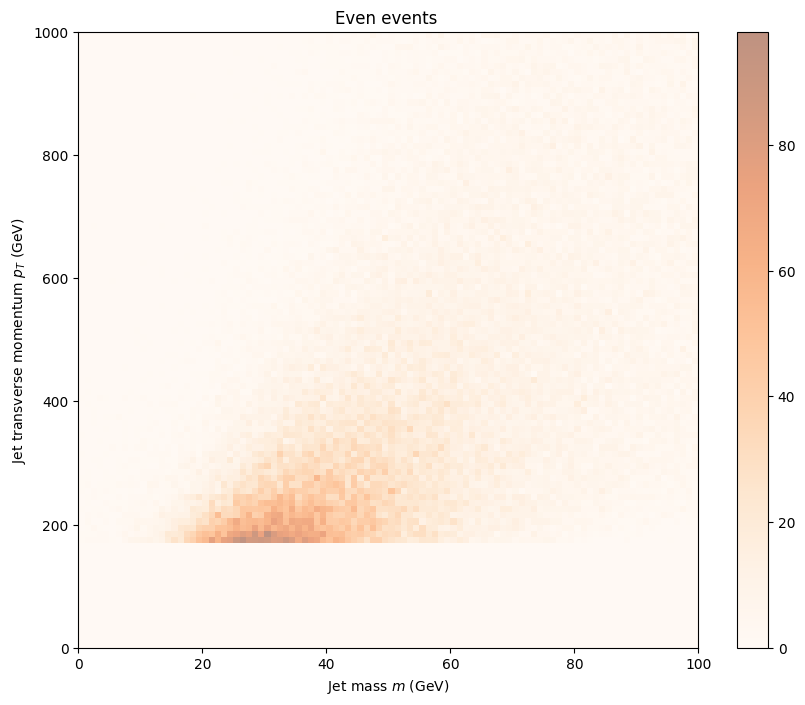

In [15]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(even_reco[:, 0], even_reco[:, 1], bins=(np.linspace(0,100,101), np.linspace(0,1000,101)), cmap='Oranges', alpha=0.5, label="Data, true")
plt.colorbar()
plt.xlabel("Jet mass $m$ (GeV)")
plt.ylabel("Jet transverse momentum $p_T$ (GeV)")
plt.title("Even events ")
plt.show()

In [16]:
#Defining the cnn model with 3 full connected layers, 2D input, 50 nodes per. Sigmoid output, as its binary classification
inputs = Input((2,))  # 2D input
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

In [17]:
myweights = of.omnifold(theta0,even_reco,20,model)

theta0G (149480, 2), labels (149480,), labels unknown (149480,), theta 0(149480, 2, 2), theta unknown s(149480, 2)
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15/15 ━━━━━━━━

In [18]:
print("Shape odd_gen:", odd_gen.shape)
print("Shape weights:", myweights.shape)


Shape odd_gen: (149480, 2)
Shape weights: (20, 2, 149480)


In [83]:
myweights[19,1,:]

array([1.00077784, 1.00077784, 1.00077784, ..., 1.00077784, 1.00077784,
       1.00077784])

In [79]:
reco_to_gen_weights = reweight(odd_reco)

TypeError: reweight() missing 1 required positional argument: 'model'

In [64]:
reco_to_gen_weights

array([1.0007778, 1.0007778, 1.0007778, ..., 1.0007778, 1.0007778,
       1.0007778], dtype=float32)

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
        149480.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

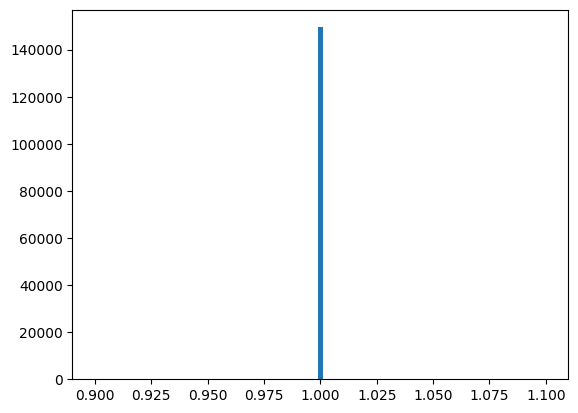

In [43]:
plt.hist(reco_to_gen_weights, bins=np.linspace(0.9, 1.1, 100) )

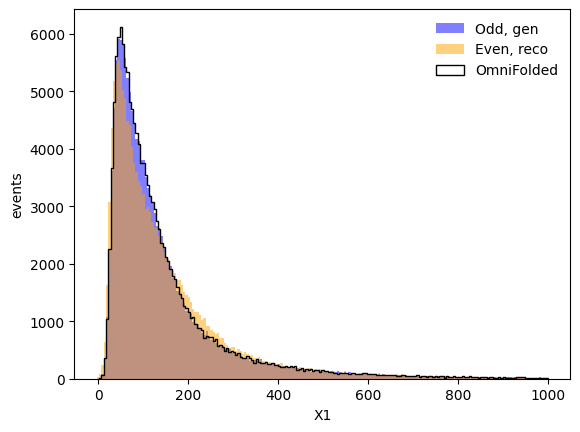

In [78]:
_,_,_=plt.hist(odd_gen[:,0],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="Odd, gen")
#_,_,_=plt.hist(even_gen[:,0],bins=np.linspace(-3,1000,200),color=['orange'],alpha=0.5,label="Even, gen")
_,_,_=plt.hist(even_reco[:,0],bins=np.linspace(-3,1000,200),color=['orange'],alpha=0.5,label="Even, reco")
_,_,_=plt.hist(even_gen[:,0],bins=np.linspace(-3,1000,200),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
plt.xlabel("X1")
plt.ylabel("events")
plt.legend(frameon=False)

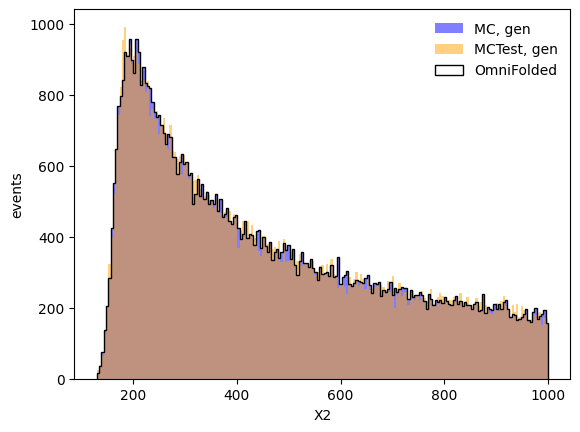

In [20]:
 _,_,_=plt.hist(odd_gen[:,1],bins=np.linspace(130,1000,200),color=['blue'],alpha=0.5,label="MC, gen")
_,_,_=plt.hist(even_gen[:,1],bins=np.linspace(130,1000,200),color=['orange'],alpha=0.5,label="MCTest, gen")
_,_,_=plt.hist(odd_gen[:,1],bins=np.linspace(130,1000,200),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
#_,_,_=plt.hist(odd_reco[:,1],bins=np.linspace(170,171,20),color=['green'],alpha=0.5, histtype="step",label="got")
plt.xlabel("X2")
plt.ylabel("events")
plt.legend(frameon=False)

In [ ]:
_,_,_=plt.hist(odd_gen[:,0],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="MC, gen")
_,_,_=plt.hist(even_gen[:,0],bins=np.linspace(-3,1000,200),color=['orange'],alpha=0.5,label="MCTest, gen")
_,_,_=plt.hist(odd_gen[:,0],bins=np.linspace(-3,1000,200),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
plt.xlabel("X1")
plt.ylabel("events")
plt.legend(frameon=False)

[0.92671853 1.11743116 0.95501536 ... 0.34344113 1.27837372 0.1965154 ]


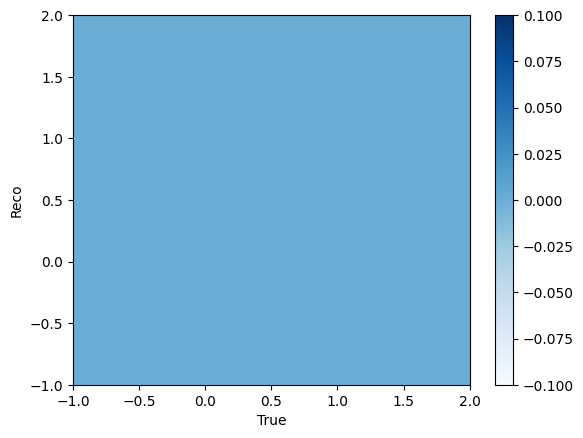

In [21]:
print(myweights[1, 0,:])
#Draw the response matrix    
plt.figure(1)
G, xbins2d, ybins2d, patches2d = plt.hist2d(even_reco[:,0],even_gen[:,0], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
plt.xlabel('True')
plt.ylabel('Reco')
plt.colorbar()

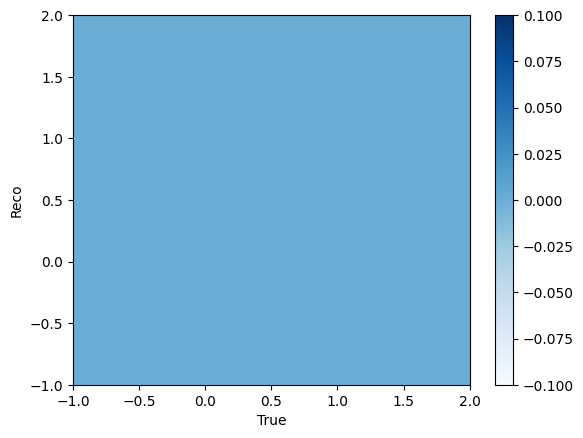

In [22]:
# Draw the response matrix    
plt.figure(1)
G, xbins2d, ybins2d, patches2d = plt.hist2d(even_reco[:,1],even_gen[:,1], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
plt.xlabel('True')
plt.ylabel('Reco')
plt.colorbar()